# Randomization metric
We run MPRT (randomization) from Quantus on our explainer and compare to a random baseline.

In [1]:
import warnings
warnings.filterwarnings('ignore') # disable warnings related to versions of tf
import numpy as np
import dianna
import quantus

2024-01-09 12:41:10.318569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


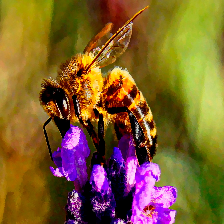

In [2]:
def load_img(path, target_size):
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications.resnet50 import preprocess_input
    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

bee_img, bee_arr = load_img('data/bee.jpg', (224,224,3))
bee_img

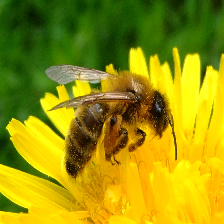

In [3]:
from pathlib import Path

reference_img, reference_arr = load_img(
    Path('data/bee2.jpg'),
    (224, 224, 3))
reference_img

In [4]:
import matplotlib.pyplot as plt

def plot_hist(result):
    data = []
    for key, value in result.items():
        for _ in range(int(value)):
            data.append(key)

    # plot the histogram
    plt.hist(data, bins=range(0, 101, 10), align='mid')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Results')
    plt.show()

In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
model = ResNet50()

def random_xai(model, input_data, method, labels, **kwargs):
    output = np.random.randn(*input_data.shape[:-1])[None,...]
    return output

random_result = quantus.MPRT()(
    model=model,
    x_batch=bee_arr,
    y_batch=[309],
    a_batch=None,
    explain_func=random_xai,
    explain_func_kwargs={'model_or_function': model,
                        "input_data": bee_arr[0],
                        "method": "RISE",
                        "labels": range(1),
                       },
    batch_size=1
)
print(random_result)

{'original': [0.0010988913973340694], 'predictions': [-0.0016282813507141186], 'conv5_block3_3_bn': [-0.0031248966121986983], 'conv5_block3_3_conv': [-0.0017905983462931266], 'conv5_block3_2_bn': [0.0011855397968340423], 'conv5_block3_2_conv': [-0.0057269728092679125], 'conv5_block3_1_bn': [0.0011855397968340423], 'conv5_block3_1_conv': [-0.0057269728092679125], 'conv5_block2_3_bn': [-0.0031248966121986983], 'conv5_block2_3_conv': [-0.0017905983462931266], 'conv5_block2_2_bn': [0.0011855397968340423], 'conv5_block2_2_conv': [-0.0057269728092679125], 'conv5_block2_1_bn': [0.0011855397968340423], 'conv5_block2_1_conv': [-0.0057269728092679125], 'conv5_block1_3_bn': [-0.0031248966121986983], 'conv5_block1_0_bn': [-0.0031248966121986983], 'conv5_block1_3_conv': [-0.0017905983462931266], 'conv5_block1_0_conv': [-0.0017905983462931266], 'conv5_block1_2_bn': [0.0011855397968340423], 'conv5_block1_2_conv': [-0.0057269728092679125], 'conv5_block1_1_bn': [0.0011855397968340423], 'conv5_block1_1_

In [6]:
import distance_explainer.distance
# import importlib
# importlib.reload(distance_explainer.distance)

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50
model = ResNet50()
embedded_reference = model(reference_arr)

img_shape = bee_arr.shape[1:3]
n_masks = 500
masks = distance_explainer.distance.generate_masks_for_images(img_shape, n_masks, 0.5, 8)

channel_first = True  # transpose to always have channels first (pytorch style)

def explain(model, inputs, targets, **kwargs) -> np.ndarray:
    """

    :param model:
    :param inputs:
    :param targets: Ignored, added because of required signature (source: https://captum.ai/api/gradient_shap.html#captum.attr.GradientShap.attribute)
    :param kwargs:
    :return:
    """

    if channel_first:
        inputst = inputs.transpose([0,2,3,1])
    else:
        inputst = inputs

    # see C:\Users\ChristiaanMeijer\anaconda3\envs\distance_explainer311\Lib\site-packages\quantus\functions\explanation_func.py
    batch_size = inputst.shape[0]
    saliencies = np.empty(inputst.shape)
    for i in range(batch_size):
        saliencies[i], _ = distance_explainer.distance.DistanceExplainer(axis_labels=['x','y','channels'], n_masks=n_masks).explain_image_distance(model, inputst[i], embedded_reference, masks=masks)

    # See quantus\metrics\base.py:l425 Channels first!
    if channel_first:
        return saliencies.transpose([0,3,1,2])
    else:
        return saliencies

In [8]:
from pandas import DataFrame

if True:
    x_batch = bee_arr.transpose([0,3,1,2])
else:
    x_batch = bee_arr

result = []
for i in range(1):
    result.append(quantus.MPRT()(
        model=model,
        x_batch=x_batch,
        y_batch=[0],
        a_batch=None,
        channel_first=channel_first,
        explain_func=explain,
        batch_size=1
    ))
r_df = DataFrame(result)
print(r_df)
print(r_df.describe())

Explaining: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.48it/s]


  original           predictions     conv5_block3_3_bn   conv5_block3_3_conv  \
0    [1.0]  [0.2854848484644563]  [0.2854848484644563]  [0.2854848484644563]   

      conv5_block3_2_bn    conv5_block3_2_conv      conv5_block3_1_bn  \
0  [0.2854848484644563]  [0.29002432657481997]  [0.29002432657481997]   

     conv5_block3_1_conv      conv5_block2_3_bn    conv5_block2_3_conv  ...  \
0  [0.29002432657481997]  [0.29002432657481997]  [0.29002432657481997]  ...   

     conv2_block1_3_bn    conv2_block1_0_bn  conv2_block1_3_conv  \
0  [0.270548752722277]  [0.270548752722277]  [0.270548752722277]   

   conv2_block1_0_conv    conv2_block1_2_bn    conv2_block1_2_conv  \
0  [0.270548752722277]  [0.270548752722277]  [0.27326686545089474]   

       conv2_block1_1_bn    conv2_block1_1_conv               conv1_bn  \
0  [0.27326686545089474]  [0.27326686545089474]  [0.27326686545089474]   

             conv1_conv  
0  [0.2832874399686998]  

[1 rows x 108 columns]
       original           pred

The numbers are Spearman correlations of all the values in two saliency maps; the original compared to that generated using a model where layers are randomized. The first number ("original") has no layers randomized, so Spearman correlation is 1 (exactly equal). From then on, first the top layer is randomized, then the next, etc.

Randomizing the top layer (predictions) apparantly is the only impactful change; after that, no more significant change in the correlation can be seen. Still, there seems to be some correlation left, which is interesting. But is this (~0.29) a meaningful correlation? Or is this just random noise?

# EXPERIMENTATION

We're trying to get images out of the quantus thing, like they do in the MPRT paper, because they look fancy schmancy. :sunglasses:

In [10]:
from quantus.metrics.randomisation.mprt import MPRT

In [37]:
import warnings
from typing import (
    Any,
    Callable,
    Collection,
    Dict,
    List,
    Optional,
    Union,
    Tuple,
    Generator,
    Iterable,
)

import numpy as np
from tqdm.auto import tqdm
from sklearn.utils import gen_batches

from quantus.functions.similarity_func import correlation_spearman
from quantus.helpers import asserts, warn
from quantus.helpers.enums import (
    DataType,
    EvaluationCategory,
    ModelType,
    ScoreDirection,
)
from quantus.helpers.model.model_interface import ModelInterface
from quantus.metrics.base import Metric

class NicePicturesMPRT(MPRT):
    def __call__(
        self,
        model,
        x_batch: np.ndarray,
        y_batch: np.ndarray,
        a_batch: Optional[np.ndarray] = None,
        s_batch: Optional[np.ndarray] = None,
        channel_first: Optional[bool] = None,
        explain_func: Optional[Callable] = None,
        explain_func_kwargs: Optional[Dict] = None,
        model_predict_kwargs: Optional[Dict] = None,
        softmax: Optional[bool] = False,
        device: Optional[str] = None,
        batch_size: int = 64,
        **kwargs,
    ) -> Union[List[float], float, Dict[str, List[float]], Collection[Any]]:
        """
        See original MPRT docstring.
        """
        # THIS IS WHAT WE ADDED
        self.a_instance_perturbed_output = []
        # THIS IS WHAT WE ADDED

        # Run deprecation warnings.
        warn.deprecation_warnings(kwargs)
        warn.check_kwargs(kwargs)
        self.batch_size = batch_size
        data = self.general_preprocess(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            a_batch=a_batch,
            s_batch=s_batch,
            custom_batch=None,
            channel_first=channel_first,
            explain_func=explain_func,
            explain_func_kwargs=explain_func_kwargs,
            model_predict_kwargs=model_predict_kwargs,
            softmax=softmax,
            device=device,
        )
        model: ModelInterface = data["model"]  # type: ignore
        # Here _batch refers to full dataset.
        x_full_dataset = data["x_batch"]
        y_full_dataset = data["y_batch"]
        a_full_dataset = data["a_batch"]

        # Results are returned/saved as a dictionary not as a list as in the super-class.
        self.evaluation_scores = {}

        # Get number of iterations from number of layers.
        n_layers = model.random_layer_generator_length
        pbar = tqdm(
            total=n_layers * len(x_full_dataset), disable=not self.display_progressbar
        )
        if self.display_progressbar:
            # Set property to False, so we display only 1 pbar.
            self._display_progressbar = False

        with pbar as pbar:
            for l_ix, (layer_name, random_layer_model) in enumerate(
                model.get_random_layer_generator(order=self.layer_order, seed=self.seed)
            ):
                pbar.desc = layer_name

                if l_ix == 0:

                    # Generate explanations on original model in batches.
                    a_original_generator = self.generate_explanations(
                        model.get_model(), x_full_dataset, y_full_dataset, batch_size
                    )

                    # Compute the similarity of explanations of the original model.
                    self.evaluation_scores["original"] = []
                    for a_batch, a_batch_original in zip(
                        self.generate_a_batches(a_full_dataset), a_original_generator
                    ):
                        for a_instance, a_instance_original in zip(
                            a_batch, a_batch_original
                        ):
                            self.a_instance_perturbed_output.append(a_instance_original)
                            score = self.evaluate_instance(
                                model=model,
                                x=None,
                                y=None,
                                s=None,
                                a=a_instance,
                                a_perturbed=a_instance_original,
                            )
                            # Save similarity scores in a result dictionary.
                            self.evaluation_scores["original"].append(score)
                            pbar.update(1)

                # Skip layers if computing delta.
                if self.skip_layers and (l_ix + 1) < n_layers:
                    continue

                self.evaluation_scores[layer_name] = []

                # Generate explanations on perturbed model in batches.
                a_perturbed_generator = self.generate_explanations(
                    random_layer_model, x_full_dataset, y_full_dataset, batch_size
                )

                # Compute the similarity of explanations of the perturbed model.
                for a_batch, a_batch_perturbed in zip(
                    self.generate_a_batches(a_full_dataset), a_perturbed_generator
                ):
                    for a_instance, a_instance_perturbed in zip(
                        a_batch, a_batch_perturbed
                    ):
                        # THIS IS WHAT WE ADDED
                        self.a_instance_perturbed_output.append(a_instance_perturbed)
                        # THIS IS WHAT WE ADDED

                        score = self.evaluate_instance(
                            model=random_layer_model,
                            x=None,
                            y=None,
                            s=None,
                            a=a_instance,
                            a_perturbed=a_instance_perturbed,
                        )
                        self.evaluation_scores[layer_name].append(score)
                        pbar.update(1)

        if self.return_average_correlation:
            self.evaluation_scores = self.recompute_average_correlation_per_sample()

        elif self.return_last_correlation:
            self.evaluation_scores = self.recompute_last_correlation_per_sample()

        if self.return_aggregate:
            assert self.return_average_correlation or self.return_last_correlation, (
                "Set 'return_average_correlation' or 'return_last_correlation'"
                " to True in order to compute the aggregate evaluation results."
            )
            self.evaluation_scores = [self.aggregate_func(self.evaluation_scores)]

        # Return all_evaluation_scores according to Quantus.
        self.all_evaluation_scores.append(self.evaluation_scores)

        return self.evaluation_scores

In [42]:
n_masks = 5
masks = distance_explainer.distance.generate_masks_for_images(img_shape, n_masks, 0.5, 8)

# --

if True:
    x_batch = bee_arr.transpose([0,3,1,2])
else:
    x_batch = bee_arr

onze_MPRT = NicePicturesMPRT()
result = []
for i in range(1):
    result.append(onze_MPRT(
        model=model,
        x_batch=x_batch,
        y_batch=[0],
        a_batch=None,
        channel_first=channel_first,
        explain_func=explain,
        batch_size=1
    ))
r_df = DataFrame(result)
print(r_df)
print(r_df.describe())

onze_MPRT.a_instance_perturbed_output

Explaining: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


               original            predictions      conv5_block3_3_bn  \
0  [0.9999999999999998]  [0.29311974460512025]  [0.29311974460512025]   

     conv5_block3_3_conv      conv5_block3_2_bn    conv5_block3_2_conv  \
0  [0.29311974460512025]  [0.29311974460512025]  [0.29311974460512025]   

       conv5_block3_1_bn    conv5_block3_1_conv      conv5_block2_3_bn  \
0  [0.29311974460512025]  [0.29311974460512025]  [0.29311974460512025]   

     conv5_block2_3_conv  ...      conv2_block1_3_bn      conv2_block1_0_bn  \
0  [0.29311974460512025]  ...  [0.29311974460512025]  [0.29311974460512025]   

     conv2_block1_3_conv    conv2_block1_0_conv      conv2_block1_2_bn  \
0  [0.29311974460512025]  [0.29311974460512025]  [0.29311974460512025]   

     conv2_block1_2_conv      conv2_block1_1_bn    conv2_block1_1_conv  \
0  [0.29311974460512025]  [0.29311974460512025]  [0.29311974460512025]   

                conv1_bn             conv1_conv  
0  [0.29311974460512025]  [0.29311974460512025] 

[array([[[0.07438904, 0.03785586, 0.00132275, ..., 0.93424034,
          0.94734192, 0.96044344],
         [0.11293775, 0.07942808, 0.04591835, ..., 0.92819351,
          0.94129503, 0.95439661],
         [0.15148652, 0.12100029, 0.090514  , ..., 0.92214662,
          0.9352482 , 0.94834971],
         ...,
         [0.61501634, 0.66540694, 0.71579742, ..., 0.8599773 ,
          0.86980343, 0.87962961],
         [0.62106323, 0.67145377, 0.72184432, ..., 0.83201057,
          0.8408289 , 0.84964722],
         [0.62711012, 0.67750061, 0.72789115, ..., 0.80404383,
          0.81185436, 0.8196649 ]],
 
        [[0.07438904, 0.03785586, 0.00132275, ..., 0.93424034,
          0.94734192, 0.96044344],
         [0.11293775, 0.07942808, 0.04591835, ..., 0.92819351,
          0.94129503, 0.95439661],
         [0.15148652, 0.12100029, 0.090514  , ..., 0.92214662,
          0.9352482 , 0.94834971],
         ...,
         [0.61501634, 0.66540694, 0.71579742, ..., 0.8599773 ,
          0.86980343, 0.

For some weird reason, the attributions are duplicated three times... fine.

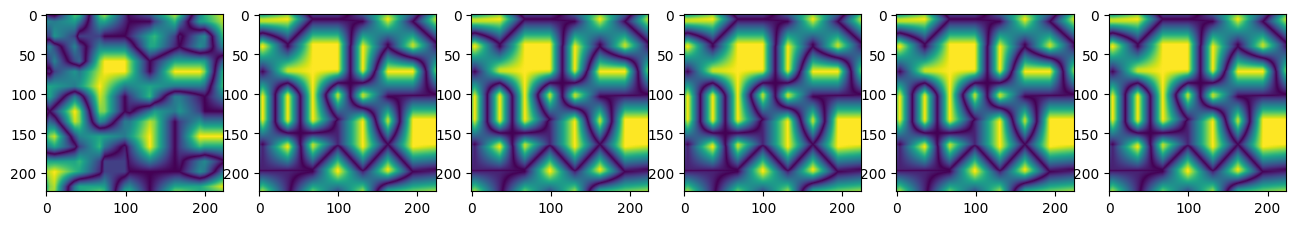

In [67]:
random_duplicate_axis = 0 # see note above

plot_N_layers = 5
fig, ax = plt.subplots(1, plot_N_layers + 1, figsize=(16,10))

plot_step_layers = 20

# original (zeroth element) and layer 1...N randomized
for ax_ix, layer in enumerate(range(0, plot_step_layers * (plot_N_layers + 1), plot_step_layers)):
    ax[ax_ix].imshow(onze_MPRT.a_instance_perturbed_output[layer][random_duplicate_axis])